Implement your own version of the dropout layer by using Bernoulli distribution and compare
the performance with the library.

With nn.Dropout

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import PIL.Image as Image
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import AlexNet_Weights
from torchvision import transforms as T
import matplotlib.pyplot as plt

In [3]:
EPOCHS = 10
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_TEST = 100
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRANSFORM = T.Compose([
    T.ToTensor(),
    T.Resize([224, 224]),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
CLASSES = {'dogs': 0, 'cats': 1}


NN_DROPOUT = {'train': [], 'test': []}
CUSTOM_DROPOUT = {'train': [], 'test': []}

In [4]:
def get_df(path, classes=['dogs', 'cats']):
    paths = pd.DataFrame({'class': [], 'path': []})
    for c in classes:
        df = pd.DataFrame({
            'class': c,
            'path': glob.glob(path + c + '/*')
        })

        paths = pd.concat([paths, df])

    paths.reset_index(inplace=False)

    return paths

class CatDogDataset(Dataset):
    def __init__(self, df, classes, transform=None):
        self.paths = df
        self.classes = classes
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        row = self.paths.iloc[idx]
        img = Image.open(row['path'])
        if self.transform is not None:
            return self.transform(img), self.classes[row['class']]
        else:
            return img, self.classes[row['class']]

def get_model_nn_dropout(dropout=0.5):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights=AlexNet_Weights.DEFAULT)
    model.features.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=dropout),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, 2),
    )
    return model

In [5]:
def train(model, train_loader, criterion, optimizer, device="cpu"):
    model.train()
    running_loss = 0.0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * len(data)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    running_loss /= len(train_loader.dataset)
    acc = 100. * correct / len(train_loader.dataset)
    return acc, running_loss

def test(model, test_loader, criterion, device="cpu"):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            running_loss += criterion(output, target).item() * len(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    running_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    return acc, running_loss

In [6]:
train_dataset = CatDogDataset(get_df('./data/cats_and_dogs_filtered/train/'), CLASSES, TRANSFORM)
test_dataset = CatDogDataset(get_df('./data/cats_and_dogs_filtered/validation/'), CLASSES, TRANSFORM)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=True)

In [7]:
model1 = get_model_nn_dropout().to(DEVICE)

Using cache found in /home/vi-b-04/.cache/torch/hub/pytorch_vision_v0.10.0


In [8]:
print(model1)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(model1.parameters(), lr=LR)

In [10]:
for epoch in range(1, EPOCHS + 1):
    print(f"Epoch: {epoch}")

    print("\tTraining: ")
    train_acc, train_loss = train(model1, train_loader, criterion, optimizer1, DEVICE)
    print("\t\tAccuracy: {:.4}%".format(train_acc))
    print("\t\tLoss: {:.4}".format(train_loss))

    print("\tValidation: ")
    test_acc, test_loss = test(model1, test_loader, criterion, DEVICE)
    print("\t\tAccuracy: {:.4}%".format(test_acc))
    print("\t\tLoss: {:.4}".format(test_loss))

    NN_DROPOUT['train'].append(train_acc.item())
    NN_DROPOUT['test'].append(test_acc.item())

Epoch: 1
	Training: 
		Accuracy: 80.4%
		Loss: 0.4313
	Validation: 
		Accuracy: 95.1%
		Loss: 0.1991
Epoch: 2
	Training: 
		Accuracy: 93.0%
		Loss: 0.212
	Validation: 
		Accuracy: 95.1%
		Loss: 0.1395
Epoch: 3
	Training: 
		Accuracy: 94.3%
		Loss: 0.1549
	Validation: 
		Accuracy: 95.1%
		Loss: 0.1227
Epoch: 4
	Training: 
		Accuracy: 94.55%
		Loss: 0.1336
	Validation: 
		Accuracy: 95.2%
		Loss: 0.1243
Epoch: 5
	Training: 
		Accuracy: 95.65%
		Loss: 0.1141
	Validation: 
		Accuracy: 95.5%
		Loss: 0.115
Epoch: 6
	Training: 
		Accuracy: 95.4%
		Loss: 0.1092
	Validation: 
		Accuracy: 96.1%
		Loss: 0.09532
Epoch: 7
	Training: 
		Accuracy: 96.9%
		Loss: 0.08608
	Validation: 
		Accuracy: 95.0%
		Loss: 0.1218
Epoch: 8
	Training: 
		Accuracy: 96.85%
		Loss: 0.08126
	Validation: 
		Accuracy: 96.1%
		Loss: 0.09737
Epoch: 9
	Training: 
		Accuracy: 97.3%
		Loss: 0.07366
	Validation: 
		Accuracy: 96.1%
		Loss: 0.08885
Epoch: 10
	Training: 
		Accuracy: 97.6%
		Loss: 0.05905
	Validation: 
		Accuracy: 95

With CustomDropout

In [11]:
class CustomDropout(nn.Module):
    def __init__(self, p):
        super(CustomDropout, self).__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.empty_like(x).bernoulli_(1 - self.p)
            return x * mask / (1 - self.p)
        else:
            return x

def get_model_custom_dropout(dropout=0.5):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights=AlexNet_Weights.DEFAULT)
    model.features.requires_grad = False
    model.classifier = nn.Sequential(
        CustomDropout(p=dropout),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        CustomDropout(p=dropout),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, 2),
    )
    return model

In [12]:
model2 = get_model_custom_dropout().to(DEVICE)

Using cache found in /home/vi-b-04/.cache/torch/hub/pytorch_vision_v0.10.0


In [13]:
print(model2)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): CustomDropout()
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(i

In [14]:
optimizer2 = optim.SGD(model2.parameters(), lr=LR)

In [15]:
for epoch in range(1, EPOCHS + 1):
    print(f"Epoch: {epoch}")

    print("\tTraining: ")
    train_acc, train_loss = train(model2, train_loader, criterion, optimizer2, DEVICE)
    print("\t\tAccuracy: {:.4}%".format(train_acc))
    print("\t\tLoss: {:.4}".format(train_loss))

    print("\tValidation: ")
    test_acc, test_loss = test(model2, test_loader, criterion, DEVICE)
    print("\t\tAccuracy: {:.4}%".format(test_acc))
    print("\t\tLoss: {:.4}".format(test_loss))

    CUSTOM_DROPOUT['train'].append(train_acc.item())
    CUSTOM_DROPOUT['test'].append(test_acc.item())

Epoch: 1
	Training: 
		Accuracy: 80.55%
		Loss: 0.4322
	Validation: 
		Accuracy: 95.5%
		Loss: 0.2022
Epoch: 2
	Training: 
		Accuracy: 92.45%
		Loss: 0.2137
	Validation: 
		Accuracy: 94.7%
		Loss: 0.1493
Epoch: 3
	Training: 
		Accuracy: 93.75%
		Loss: 0.1584
	Validation: 
		Accuracy: 95.9%
		Loss: 0.1123
Epoch: 4
	Training: 
		Accuracy: 94.35%
		Loss: 0.1487
	Validation: 
		Accuracy: 95.0%
		Loss: 0.1274
Epoch: 5
	Training: 
		Accuracy: 96.25%
		Loss: 0.1176
	Validation: 
		Accuracy: 96.1%
		Loss: 0.1039
Epoch: 6
	Training: 
		Accuracy: 96.25%
		Loss: 0.101
	Validation: 
		Accuracy: 96.0%
		Loss: 0.09166
Epoch: 7
	Training: 
		Accuracy: 96.9%
		Loss: 0.08483
	Validation: 
		Accuracy: 95.7%
		Loss: 0.1055
Epoch: 8
	Training: 
		Accuracy: 96.5%
		Loss: 0.08265
	Validation: 
		Accuracy: 95.0%
		Loss: 0.1202
Epoch: 9
	Training: 
		Accuracy: 97.6%
		Loss: 0.06482
	Validation: 
		Accuracy: 94.7%
		Loss: 0.1299
Epoch: 10
	Training: 
		Accuracy: 98.0%
		Loss: 0.06676
	Validation: 
		Accuracy: 

Comparison

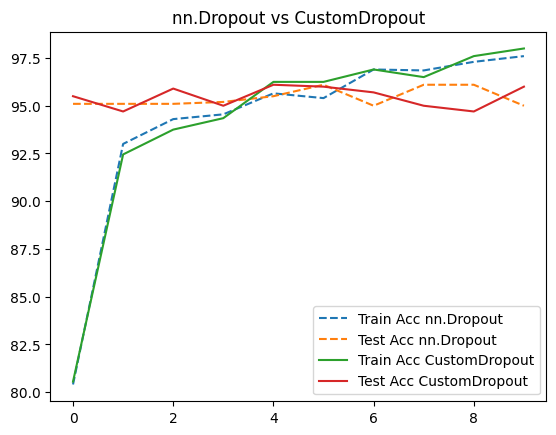

In [16]:
plt.plot(NN_DROPOUT['train'], '--', label='Train Acc nn.Dropout')
plt.plot(NN_DROPOUT['test'], '--', label='Test Acc nn.Dropout')
plt.plot(CUSTOM_DROPOUT['train'], label='Train Acc CustomDropout')
plt.plot(CUSTOM_DROPOUT['test'], label='Test Acc CustomDropout')
plt.title('nn.Dropout vs CustomDropout')
plt.legend()
plt.show()